# Classification with Random Forest

## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

## Import and view data

In [2]:
df = pd.read_csv("data/train_prepd.csv")
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
0,0.0,3.0,22.0,7.2500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,7.9250,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,3.0,35.0,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


dims:  (891, 13)


Data have already been preprocessed, as part of the EDA step. Including one-hot encoding and imputation of missing values.

Split into dependent and independent variables.

In [3]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary classification tree

Split into testing and training data.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 420)

Build and train a simple random forest classifier. Use to predict test values.

Accuracy: 84.36 %


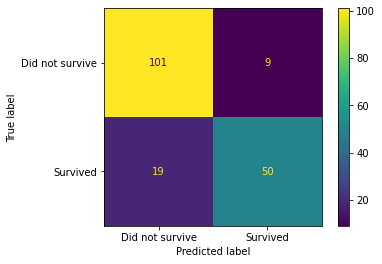

In [5]:
# build the model shell and fit onto the training data.
clf_prel = RandomForestClassifier(random_state=420)
clf_prel.fit(X_train, y_train)

# predict
y_pred = clf_prel.predict(X_test)

# results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(clf_prel, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

Use the model to predict training values in order to assess overfitting.

Accuracy: 99.58 %


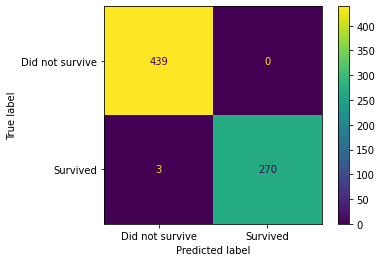

In [6]:
y_pred_tr = clf_prel.predict(X_train)

acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)

print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(clf_prel, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Use 10-fold cross validation to get a more robust estimate of the model's accuracy.

In [15]:
scores = cross_val_score(clf_prel, X, y, cv=10)
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

scores:  [0.8        0.88764045 0.76404494 0.84269663 0.85393258 0.88764045
 0.79775281 0.80898876 0.8988764  0.87640449]
Accuracy: 84.18 %
St.dev: 0.0443


## Hyper-parameter tuning

Random forest tends to perform quite well out of the box. We will try tuning some of the hyper-parameters to see if we can get an increase in accuracy. We'll mostly try a couple different values for maximum tree depth to see if we can reduce overfitting.

In [8]:
# Set up the hyper-parameter grid for Grid Search.

params = {'max_features': ['sqrt'], 
        'criterion': ['gini', 'entropy'], 
        'max_depth': [2, 4, 6, 8, 10]}

In [9]:
# build the shell model and fit on training data.
clf = RandomForestClassifier(random_state=420)
gs = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1, cv=10)
gs.fit(X_train, y_train)

# print the best models and hyper-parameters
results = gs.cv_results_
best = gs.best_params_
display(pd.DataFrame(results).sort_values(by='rank_test_score').head(3))
print('best values of hyper-parameters', best)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
8,0.145986,0.010114,0.010610,0.000917,entropy,8,sqrt,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.861111,0.791667,...,0.845070,0.830986,0.830986,0.901408,0.802817,0.887324,0.802817,0.845559,0.038997,1
3,0.144331,0.009028,0.011110,0.001045,gini,8,sqrt,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.847222,0.777778,...,0.859155,0.845070,0.830986,0.901408,0.802817,0.887324,0.802817,0.842782,0.037684,2
4,0.149336,0.014824,0.012011,0.002759,gini,10,sqrt,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.847222,0.763889,...,0.816901,0.859155,0.816901,0.915493,0.802817,0.887324,0.774648,0.838576,0.049621,3


best values of hyper-parameters {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt'}


## Build the final model

In [ ]:
clf = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt', random_state=420)





Accuracy: 82.12 %


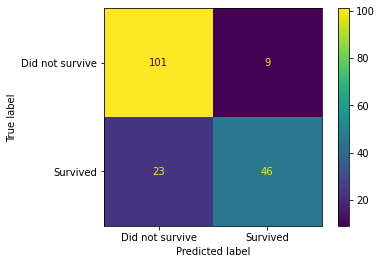

In [12]:
clf = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt', random_state=420)
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

Use 10-fold CV to get a more robust estimate of the model's accuracy.

In [14]:
scores = cross_val_score(clf, X, y, cv=10)
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

scores:  [0.82222222 0.88764045 0.75280899 0.87640449 0.91011236 0.83146067
 0.83146067 0.82022472 0.87640449 0.85393258]
Accuracy: 84.63 %
St.dev: 0.0425


Hyperparameter tuning resulted in a 0.5% increase in accuracy, with slightly lower standard deviation.